# Measuring Kinetic Energy of Coupled Classical Harmonic Oscillator Systems using Classiq
Authors: Viraj Dsouza, Cristina Radian, Kerem Yurtseven

Date: 09.08.2024

This work is designed under and for the final project of the Womanium Quantum+AI Program 2024

Reference Paper: Exponential Quantum Speedup in Simulating Coupled Classical Oscillators, Babbush et.al, 2023 [1](https://arxiv.org/abs/2303.13012)
___

## Optimization

In this notebook, we aim to optimize circuit and estimate circuit width, depth, number of 2-qubit gates in IBM Quantum Computers.

___


## Our Configuration

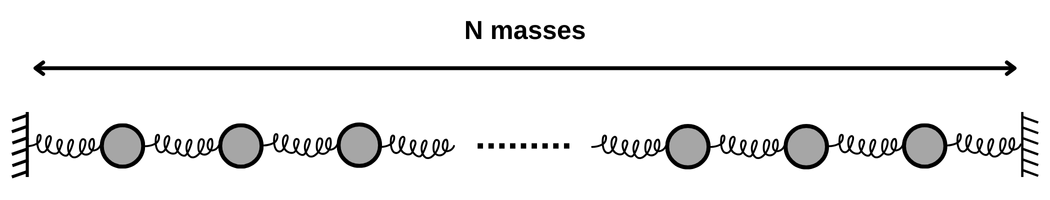

We use $N = 2^1$ masses and evolve it for a certain time. All masses are equal to 1, i.e $m_i = 1$. Also, the spring between each adjacent mass is 1 and initial and final masses are connected to the wall with a spring constant equal to 1. Initial states are chosen as $\vec{x}(t) = (0,0)^T$ and $\vec{\dot{x}}(t) = (1,0)^T$

In the post-processing, we get the final velocity vector and evalueate $\hat{k_V}(t)$ as
\begin{equation*}
    \hat{k_V}(t) = \frac{v(t)^T v(t)}{2}
    \qquad(3)
\end{equation*}

___

## Pre-Processing

Create necessary matrix and initial states using functions created in `ccho_helpers.py`

In [31]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from ccho_helpers import *
from classiq import (
    qfunc,
    QNum,
    QArray,
    QBit,
    CArray,
    CReal,
    CInt,
    QCallable,
    allocate,
    bind,
    repeat,
    CX,
    control,
    PHASE,
    Output,
    prepare_amplitudes,
    create_model,
    set_execution_preferences,
    synthesize,
    execute,
    suzuki_trotter,
    exponentiation_with_depth_constraint,
    show,
    Constraints,
    set_constraints,
    switch,
    PauliTerm,
    Pauli,
    within_apply,
    inplace_prepare_state,
    IDENTITY, X, Y, Z,
    reflect_about_zero,
    RY, U, power,
    write_qmod,
    QuantumProgram,
    OptimizationParameter
)
from classiq.execution import ExecutionPreferences, ClassiqBackendPreferences, IBMBackendPreferences, IBMBackendProvider

In [32]:
## Providing all inputs for 8 coupled SHO case and performing all the initial transformations

# Number of masses
N=2**1

# Mass Matrix
M= np.zeros([N, N])
for i in range(N):
    M[i][i] = 1

K = np.zeros([N,N])
for j in range(N):
    for t in range(j, N):
        if j == 0 or j == N-1:
            K[j][j] = 1
        if abs(j-t) == 1:
            K[j][t] = 1
            K[t][j] = 1

# Initial Conditions
x_0 = np.zeros([N,1])
xdot_0 = np.zeros([N,1])
xdot_0[0] = 1

# F Matrix
F= create_matrix_F(K, N)

# A Matrix
A = create_matrix_A(M, F)

# Transform coordinates
y = coordinate_transformation(M, x_0, xdot_0)
y_0 = y["y_0"]
ydot_0 = y["ydot_0"]

# B Matrix
B = create_matrix_B(M, K, A, N)

# Stacking B with zeros to get square matrix N^2 x N^2
B_padded = padding_B(B, N)

# Hamiltonian
H = create_Hamiltonian(B_padded)

# Initial State
init_state = create_init_state(B_padded, y_0, ydot_0, N)
E0_y = calculate_energy(y_0, ydot_0, M, K)

# Normalize the Initial State
normalization = normalize_init_state(init_state)
normalized_init_state = normalization["normalized_init_state"]
norm = normalization["norm"]

# Print the results
print("Initial Energy: ", E0_y)
print("B matrix: ", B)
print("Hamiltonian formed:", H)
print("Initial State:", init_state)

Initial Energy:  0.5
B matrix:  [[ 1.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  1.+0.j]]
Hamiltonian formed: [[-0.-0.j -0.-0.j -0.-0.j -0.-0.j -1.-0.j -1.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -1.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-1.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-1.+0.j  1.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -1.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]]
Initial State: [[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


## Pauli Matrix Decomposition

Create the Pauli List for the Hamiltonian. Pauli Decomposition is taken from [Classiq Library](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb) thanks a lot to the authors!

In [33]:
## Pauli Decomposition and transforming it into Classiq syntax

# Create the Pauli Matrix Decomposition of the Hamiltonian
pauli_list = lcu_naive(H)

# Transform Pauli Matrix Decomposition to Classiq compatible
classiq_pauli_list = pauli_list_to_hamiltonian(pauli_list)

print(pauli_list)

100%|██████████| 64/64 [00:00<00:00, 5331.81it/s]

[('XIZ', (-0.5+0j)), ('XIX', (-0.25+0j)), ('XZZ', (-0.5+0j)), ('XZX', (-0.25+0j)), ('XXX', (-0.25+0j)), ('XYY', (-0.25+0j)), ('YIY', (0.25+0j)), ('YZY', (0.25+0j)), ('YXY', (-0.25+0j)), ('YYX', (0.25+0j))]


## Hamiltonian simulation

We use the qubitization

In [34]:
## Providing all inputs for 8 coupled SHO case and performing all the initial transformations

# Number of masses
N=2**1

# Mass Matrix
M= np.zeros([N, N])
for i in range(N):
    M[i][i] = 1

K = np.zeros([N,N])
for j in range(N):
    for t in range(j, N):
        if j == 0 or j == N-1:
            K[j][j] = 1
        if abs(j-t) == 1:
            K[j][t] = 1
            K[t][j] = 1

# Initial Conditions
x_0 = np.zeros([N,1])
xdot_0 = np.zeros([N,1])
xdot_0[0] = 1

# F Matrix
F= create_matrix_F(K, N)

# A Matrix
A = create_matrix_A(M, F)

# Transform coordinates
y = coordinate_transformation(M, x_0, xdot_0)
y_0 = y["y_0"]
ydot_0 = y["ydot_0"]

# B Matrix
B = create_matrix_B(M, K, A, N)

# Stacking B with zeros to get square matrix N^2 x N^2
B_padded = padding_B(B, N)

# Hamiltonian
H = create_Hamiltonian(B_padded)

# Initial State
init_state = create_init_state(B_padded, y_0, ydot_0, N)
E0_y = calculate_energy(y_0, ydot_0, M, K)

# Normalize the Initial State
normalization = normalize_init_state(init_state)
normalized_init_state = normalization["normalized_init_state"]
norm = normalization["norm"]

# Print the results
print("Initial Energy: ", E0_y)
print("B matrix: ", B)
print("Hamiltonian formed:", H)
print("Initial State:", init_state)
## Pauli Decomposition and transforming it into Classiq syntax

# Create the Pauli Matrix Decomposition of the Hamiltonian
pauli_list = lcu_naive(H)

# Transform Pauli Matrix Decomposition to Classiq compatible
classiq_pauli_list = pauli_list_to_hamiltonian(pauli_list)

print(pauli_list)

Initial Energy:  0.5
B matrix:  [[ 1.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  1.+0.j]]
Hamiltonian formed: [[-0.-0.j -0.-0.j -0.-0.j -0.-0.j -1.-0.j -1.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -1.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-1.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-1.+0.j  1.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -1.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.+0.j -0.+0.j -0.+0.j -0.+0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]]
Initial State: [[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


100%|██████████| 64/64 [00:00<00:00, 7999.86it/s]

[('XIZ', (-0.5+0j)), ('XIX', (-0.25+0j)), ('XZZ', (-0.5+0j)), ('XZX', (-0.25+0j)), ('XXX', (-0.25+0j)), ('XYY', (-0.25+0j)), ('YIY', (0.25+0j)), ('YZY', (0.25+0j)), ('YXY', (-0.25+0j)), ('YYX', (0.25+0j))]


In [35]:
def get_cheb_coef(epsilon, t):
    """
        Definition:
            Find the Chebyshev coefficients
        Args:
            epsilon (float): Sensitivity
            t (float): Evolution time for the system
        Outputs:
            cos_coef (list): Coefficients of cosine function
            sin_coef (list): Coefficients of sine function
    """
    poly_degree = int(
        np.ceil(
            t
            + np.log(epsilon ** (-1)) / np.log(np.exp(1) + np.log(epsilon ** (-1)) / t)
        )
    )
    cos_coef = [scipy.special.jv(0, t)] + [
        2 * scipy.special.jv(2 * k, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    sin_coef = [
        -2 * scipy.special.jv(2 * k - 1, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    return cos_coef, sin_coef

In [36]:
def get_normalized_lcu_coef(lcu_coef):
    """
        Definition:
            Find the LCU probabilities, normaliziation factor, and size of the probabilities
        Args:
            lcu_coef (list): List of coefficients for Pauli matrices
        Outputs:
            normalization_factor (float): 1-norm of the coefficients
            coef_size (int): Number of Qubits to create the probabilities
            prepare_prob(list): Probabilities of normalized LCU coefficients
    """
    
    lcu_coef = [abs(c) for c in lcu_coef]
    normalization_factor = sum(lcu_coef)
    prepare_prob = [c / normalization_factor for c in lcu_coef]
    coef_size = int(np.ceil(np.log2(len(prepare_prob))))
    prepare_prob += [0] * (2**coef_size - len(prepare_prob))

    return normalization_factor, coef_size, prepare_prob

In [37]:
@qfunc
def apply_pauli_term(pauli_string: PauliTerm, state: QArray[QBit]):
    """
    Definition:
        Apply the Pauli Matrix to the state
    Args:
        pauli_string (PauliTerm): Pauli Matrix sequence
        state (QArray[QBit]): State to apply pauli matrices
    """
    repeat(
        count=state.len,
        iteration=lambda index: switch(
            pauli_string.pauli[index],
            [
                lambda: IDENTITY(state[pauli_string.pauli.len - index - 1]),
                lambda: X(state[pauli_string.pauli.len - index - 1]),
                lambda: Y(state[pauli_string.pauli.len - index - 1]),
                lambda: Z(state[pauli_string.pauli.len - index - 1]),
            ],
        ),
    )


@qfunc
def lcu_paulis(pauli_terms_list: CArray[PauliTerm], signs: CArray[CInt], probs: CArray[CReal], block: QNum, state: QArray[QBit]):
    """
        Definition:
            Apply all the Pauli sequences in LCU
        Args:
            pauli_terms_list (CArray[PauliTerm]): Pauli Matrix Decomposition of the Hamiltonian
            signs (CArray[CInt]): Signs of PMD coefficients
            probs (CArray[CReal]): Probabilities for LCU
            block (QNum): PREPARE variables
            state (QArray[QBit]): State to apply LCU
    """

    within_apply(
        lambda: inplace_prepare_state(probs, 0.0, block),
        lambda: repeat(
            count=pauli_terms_list.len,
            iteration=lambda i: control(
                block == i, lambda: (
                                U(0, 0, 0, np.pi / 2 * signs[i], state[0]),
                                apply_pauli_term(pauli_terms_list[i], state)
                ),
            ),
        )
    )

In [38]:
## Find the LCU parameters for the Hamiltonian

pauli_coeff = [p.coefficient for p in classiq_pauli_list]
signs_pauli = np.sign(pauli_coeff).tolist()
generalized_signs_pauli = [
    (1 - signs_pauli[s]) + (s) % 2 for s in range(len(signs_pauli))
]
normalization_ham, lcu_size_ham, prepare_probs_ham = get_normalized_lcu_coef(pauli_coeff)

print("Normalization factor: ", normalization_ham)
print("LCU size: ", lcu_size_ham)
print("Probabilities: ", prepare_probs_ham)
print("Signs: ", generalized_signs_pauli)

Normalization factor:  3.0
LCU size:  4
Probabilities:  [0.16666666666666666, 0.08333333333333333, 0.16666666666666666, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0, 0, 0, 0, 0, 0]
Signs:  [2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 0.0, 1.0, 2.0, 1.0]


In [39]:
@qfunc
def my_walk_operator(block: QArray[QBit], state: QArray[QBit]) -> None:
    """
        Definition:
            Applies the Szegedy Quantum Walk Operator
        Args:
            block (QArray[QBit]): PREPARE variables
            state (QArray[QBit]): State to apply walk operator
    """
    lcu_paulis(classiq_pauli_list, generalized_signs_pauli, prepare_probs_ham, block, state)
    reflect_about_zero(block)
    RY(2 * np.pi, block[0])

In [40]:
## Finc Chebyshev coefficients and take phases into account

time = 0.5

normalized_time = normalization_ham * time

cos_coef, sin_coef = get_cheb_coef(0.0001, normalized_time)

combined_sin_cos_coef = []
for k in range(len(cos_coef) - 1):
    combined_sin_cos_coef.append(cos_coef[k])
    combined_sin_cos_coef.append(sin_coef[k])
combined_sin_cos_coef.append(cos_coef[-1])
if len(sin_coef) == len(cos_coef):
    combined_sin_cos_coef.append(sin_coef[-1])

signs_cheb_coef = np.sign(combined_sin_cos_coef).tolist()
generalized_signs = [
    (1 - signs_cheb_coef[s]) + (s) % 2 for s in range(len(signs_cheb_coef))
]
positive_cheb_lcu_coef = np.abs(combined_sin_cos_coef)

In [41]:
## Find the LCU parameters for the exponentiation

normalization_exp, lcu_size_exp, prepare_probs_exp = get_normalized_lcu_coef(positive_cheb_lcu_coef)

print("Normalization factor: ", normalization_exp)
print("LCU size: ", lcu_size_exp)
print("Probabilities: ", prepare_probs_exp)

Normalization factor:  2.241395067893022
LCU size:  3
Probabilities:  [0.22835227893003768, 0.4978475378145419, 0.20709215922598068, 0.0543982201214064, 0.010500721259644947, 0.001605626596699994, 0.00020345605168833642, 0]


In [42]:
## LCU function for Chebyshev coefficients

@qfunc
def lcu_cheb(coef: CArray[CReal], generalized_signs: CArray[CInt], walk_operator: QCallable[QNum, QArray], walk_block: QNum, state: QArray, cheb_block: QNum):
    """
        Definition:
            Apply all the Chebyshev coefficients in LCU
        Args:
            coef (CArray[CReal]): Chebyshev Coefficients
            generalized_signs (CArray[CInt]): Signs of Chebyshev coefficients
            walk_operator (QCallable[QNum, QArray]): Quantum Walk-Operator
            walk_block (QNum): PREPARE variables for Quantum Walk
            state (QArray[QBit]): State to apply LCU
            cheb_block (QNum): PREPARE variables for Chebyshev coefficients
    """

    within_apply(
        lambda: inplace_prepare_state(coef, 0.0, cheb_block),
        lambda: repeat(
            generalized_signs.len,
            lambda k: control(
                cheb_block == k,
                lambda: (
                    U(0, 0, 0, np.pi / 2 * generalized_signs[k], state[0]),
                    power(k, lambda: walk_operator(walk_block, state)),
                ),
            ),
        ),
    )

In [43]:
## Main Evolution

# Add i phase for the last half
@qfunc
def init_state_phase(state: QNum):
    """
        Definition:
            Imply -pi/2 phase to the last half (msb qubit) of the QNum state in order to add -i factor
        Args:
            state (QNum): Initial state with bare amplitudes
        Outputs:
            state (QNum): Initial state with phase
    """

    state_in_qubit = QArray("state_in_qubit")
    msb = QArray("msb", QBit)
    
    size = np.log2(init_state.size)
    allocate(size, msb)

    bind(state, state_in_qubit)
    repeat(state_in_qubit.len, lambda i: CX(state_in_qubit[i], msb[i]))
    control(msb[size-1], lambda: PHASE(np.pi/2, state_in_qubit[size-1]))
    bind(state_in_qubit, state)

# Main Function
@qfunc
def main(ham_block: Output[QNum], state: Output[QNum], exp_block: Output[QNum]):
    """
        Definition:
            Main function to make evolution

        Outputs:
            ham_block (Output[QNum]): PREPARE variables for Hamiltonian
            state (Output[QNum]): Resulting state at the t = evolution_coefficient
            exp_block (Output[QNum]): PREPARE variables for exponantioation
    """

    allocate(lcu_size_exp, exp_block)
    allocate(lcu_size_ham, ham_block)
    prepare_amplitudes(list(normalized_init_state), 0.0, state)
    init_state_phase(state)

    lcu_cheb(
        prepare_probs_exp,
        generalized_signs,
        lambda x, y: my_walk_operator(x, y),
        ham_block,
        state,
        exp_block,
    )


qmod = create_model(main)
write_qmod(qmod, "OptimizationQubitization", decimal_precision=16)

In [44]:
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1, backend_preferences=backend_preferences))
qprog_qbt = synthesize(model_pref)
show(qprog_qbt)

Opening: https://platform.classiq.io/circuit/1999b548-f9af-4532-aa43-c6430f673da2?version=0.43.3


In [45]:
print("Classiq Simulator Synthesis")
syn_time_qbt = (QuantumProgram.parse_raw(qprog_qbt).synthesis_duration.preprocessing + QuantumProgram.parse_raw(qprog_qbt).synthesis_duration.solving + QuantumProgram.parse_raw(qprog_qbt).synthesis_duration.conversion_to_circuit + QuantumProgram.parse_raw(qprog_qbt).synthesis_duration.postprocessing)

transp_depth_qbt = QuantumProgram.parse_raw(qprog_qbt).transpiled_circuit.depth
transp_width_qbt = QuantumProgram.parse_raw(qprog_qbt).data.width
transp_cx_qbt = QuantumProgram.parse_raw(qprog_qbt).transpiled_circuit.count_ops["cx"]

print("Synthesis Time            : ", syn_time_qbt, "s")

print("Transpiled Circuit Depth  : ", transp_depth_qbt)
print("Transpiled Circuit Width  : ", transp_width_qbt)
print("Transpiled Circuit CX Gate: ", transp_cx_qbt)

Task exception was never retrieved
future: <Task finished name='Task-10' coro=<synthesize_async() done, defined at c:\Users\Kerem\anaconda3\Lib\site-packages\classiq\synthesis.py:16> exception=ClassiqAPIError('Synthesis process reached timeout. Please try specifying a longer timeout in the synthesis preferences. Task that timed out: generation\n\nError identifier: EF1BDE3C3-5CC7-476B-8183-2F80B09C77E0.\nIf you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack')>
Traceback (most recent call last):
  File "c:\Users\Kerem\anaconda3\Lib\asyncio\tasks.py", line 267, in __step
    result = coro.send(None)
             ^^^^^^^^^^^^^^^
  File "c:\Users\Kerem\anaconda3\Lib\site-packages\classiq\synthesis.py", line 20, in synthesize_async
    quantum_program = await ApiWrapper.call_generation_task(model)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kerem\anaconda3\Lib\site-packages\classiq\_inte

Classiq Simulator Synthesis
Synthesis Time            :  51.63329914200585 s
Transpiled Circuit Depth  :  33973
Transpiled Circuit Width  :  17
Transpiled Circuit CX Gate:  22832


In [46]:
## Define Hardware preferences and synthesize

qmod = create_model(main)
ibm_kyoto = IBMBackendPreferences(
    backend_name="ibm_kyoto",
    access_token="-",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_kyoto))
qprog_kyoto_qbt = synthesize(model_pref)

ibm_sherbrooke = IBMBackendPreferences(
    backend_name="ibm_sherbrooke",
    access_token="-",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_sherbrooke))
qprog_sherbrooke_qbt = synthesize(model_pref)

ibm_osaka = IBMBackendPreferences(
    backend_name="ibm_osaka",
    access_token="-",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_osaka))
qprog_osaka_qbt = synthesize(model_pref)

ibm_brisbane = IBMBackendPreferences(
    backend_name="ibm_brisbane",
    access_token="-",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_brisbane))
qprog_brisbane_qbt = synthesize(model_pref)

In [47]:
show(qprog_kyoto_qbt)

Opening: https://platform.classiq.io/circuit/79f9ba07-e153-444e-ac0e-252f57954ab3?version=0.43.3


In [48]:
show(qprog_osaka_qbt)

Opening: https://platform.classiq.io/circuit/fd848b10-ef2a-4028-82fd-c950d0d3997a?version=0.43.3


In [49]:
show(qprog_brisbane_qbt)

Opening: https://platform.classiq.io/circuit/dbbad5f8-55bd-484c-bb3f-2af642500e2d?version=0.43.3


In [50]:
show(qprog_sherbrooke_qbt)

Opening: https://platform.classiq.io/circuit/ea721ab1-e506-4b18-baec-0798f7f9c673?version=0.43.3


In [51]:
## Calculate resources in hardwares
hardwares_qbt = {"IBM Osaka": {"qprog": qprog_osaka_qbt, "time": 0, "depth": 0, "width": 0, "cx": 0},
             "IBM Kyoto": {"qprog": qprog_kyoto_qbt, "time": 0, "depth": 0, "width": 0, "cx": 0},
             "IBM Brisbane": {"qprog": qprog_brisbane_qbt, "time": 0, "depth": 0, "width": 0, "cx": 0},
             "IBM Sherbrooke": {"qprog": qprog_sherbrooke_qbt, "time": 0, "depth": 0, "width": 0, "cx": 0}}

for i in hardwares_qbt.keys():
    qprog_hard = hardwares_qbt[i]["qprog"]

    hardwares_qbt[i]["time"] = (QuantumProgram.parse_raw(qprog_hard).synthesis_duration.preprocessing + QuantumProgram.parse_raw(qprog_hard).synthesis_duration.solving + QuantumProgram.parse_raw(qprog_hard).synthesis_duration.conversion_to_circuit + QuantumProgram.parse_raw(qprog_hard).synthesis_duration.postprocessing)

    hardwares_qbt[i]["depth"] = QuantumProgram.parse_raw(qprog_hard).transpiled_circuit.depth
    hardwares_qbt[i]["width"] = QuantumProgram.parse_raw(qprog_hard).data.width
    hardwares_qbt[i]["cx"] = QuantumProgram.parse_raw(qprog_hard).transpiled_circuit.count_ops["cx"]

for i in  hardwares_qbt.keys():
    print(f"{i} Synthesis")
    print("Synthesis Time            : ", hardwares_qbt[i]["time"], "s")

    print("Transpiled Circuit Depth  : ", hardwares_qbt[i]["depth"])
    print("Transpiled Circuit Width  : ", hardwares_qbt[i]["width"])
    print("Transpiled Circuit CX Gate: ", hardwares_qbt[i]["cx"])
    print("-------------")

IBM Osaka Synthesis
Synthesis Time            :  49.65208969300147 s
Transpiled Circuit Depth  :  32432
Transpiled Circuit Width  :  17
Transpiled Circuit CX Gate:  21984
-------------
IBM Kyoto Synthesis
Synthesis Time            :  52.135384491994046 s
Transpiled Circuit Depth  :  34442
Transpiled Circuit Width  :  17
Transpiled Circuit CX Gate:  23164
-------------
IBM Brisbane Synthesis
Synthesis Time            :  54.68521740598953 s
Transpiled Circuit Depth  :  34486
Transpiled Circuit Width  :  17
Transpiled Circuit CX Gate:  23152
-------------
IBM Sherbrooke Synthesis
Synthesis Time            :  51.33571878101793 s
Transpiled Circuit Depth  :  33816
Transpiled Circuit Width  :  17
Transpiled Circuit CX Gate:  22826
-------------


Text(0.5, 1.0, 'CX Count')

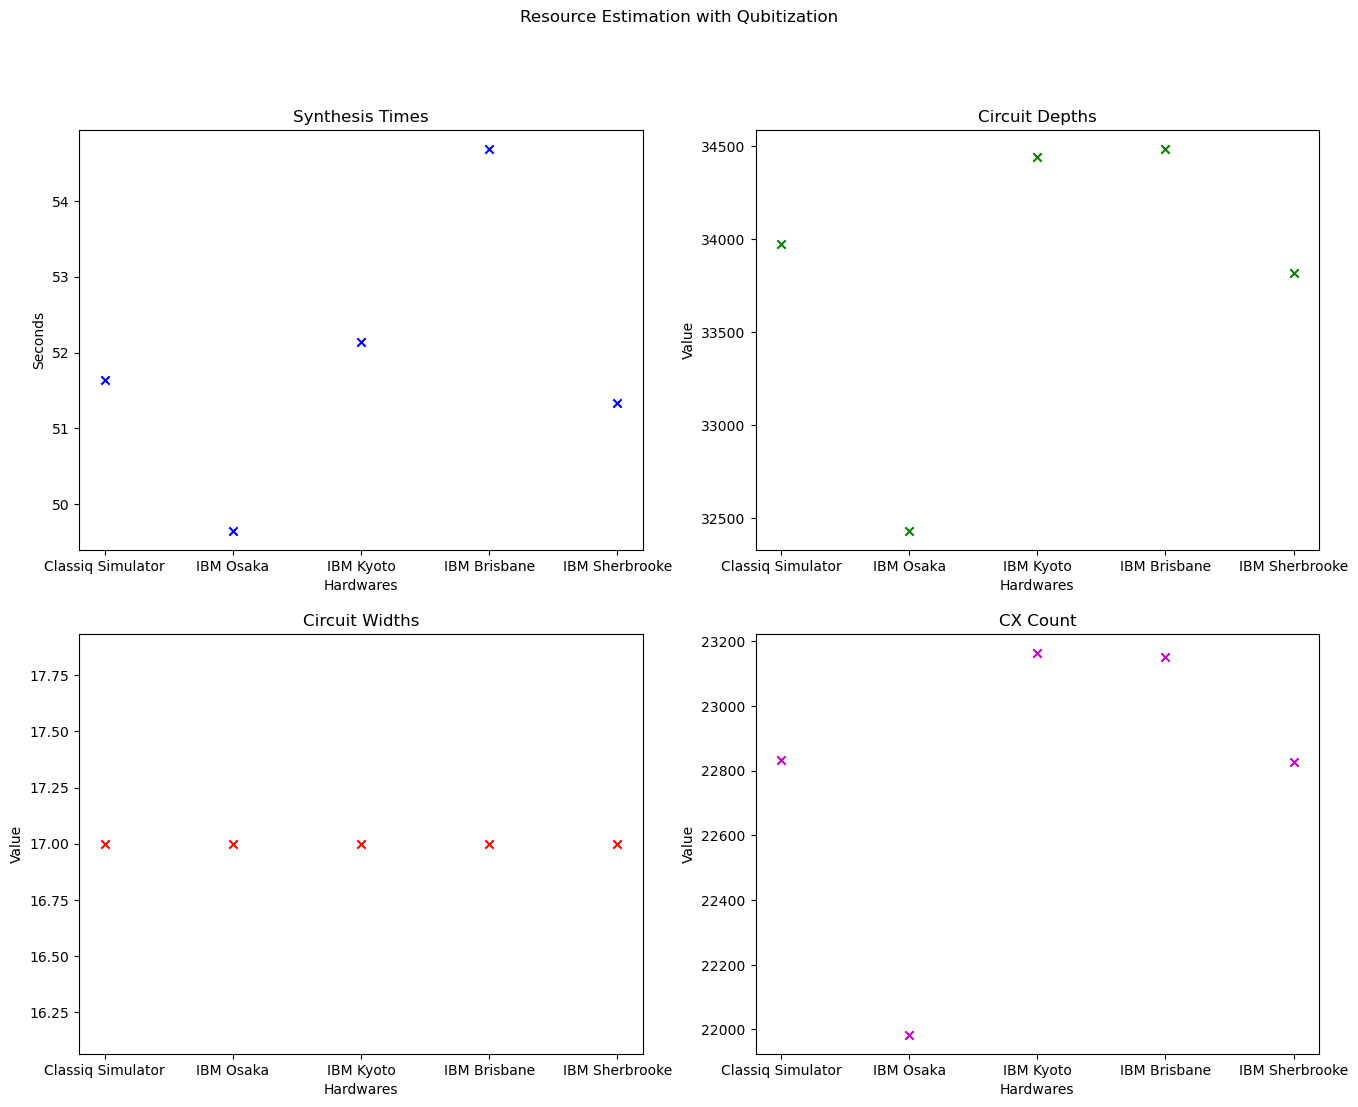

In [52]:
devices_qbt = ["Classiq Simulator"] + list(hardwares_qbt.keys())
syn_times_qbt = [syn_time_qbt] + [hardwares_qbt[i]["time"] for i in hardwares_qbt.keys()]
depths_qbt = [transp_depth_qbt] + [hardwares_qbt[i]["depth"] for i in hardwares_qbt.keys()]
widths_qbt = [transp_width_qbt] + [hardwares_qbt[i]["width"] for i in hardwares_qbt.keys()]
cxcount_qbt = [transp_cx_qbt] + [hardwares_qbt[i]["cx"] for i in hardwares_qbt.keys()]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[16,12])
fig.suptitle(r"Resource Estimation with Qubitization")
ax[0][0].set_title("Synthesis Times")
ax[0][0].set_ylabel("Seconds")
ax[0][0].set_xlabel("Hardwares")
ax[0][0].scatter(devices_qbt, syn_times_qbt, marker="x", c="b")
ax[0][1].set_title("Circuit Depths")
ax[0][1].set_ylabel("Value")
ax[0][1].set_xlabel("Hardwares")
ax[0][1].scatter(devices_qbt, depths_qbt, marker="x", c="g")
ax[1][0].set_title("Circuit Widths")
ax[1][0].set_ylabel("Value")
ax[1][0].set_xlabel("Hardwares")
ax[1][0].scatter(devices_qbt, widths_qbt, marker="x", c="r")
ax[1][1].set_title("CX Count")
ax[1][1].set_ylabel("Value")
ax[1][1].set_xlabel("Hardwares")
ax[1][1].scatter(devices_qbt, cxcount_qbt, marker="x", c="m")
ax[1][1].set_title("CX Count")

## Comparision of Hardware Resources
Necessary resources for all IBM Computers and also for `Classiq Simulator` seem same without any constraint and optimization. However, the synthesis time differs and `IBM Osaka` has the shorthest synthesis time. So, we choose `IBM Osaka` to make optimizations. Since it has 127 qubits, set maximum width smaller than 127.

In [56]:
constraints_depth = Constraints(optimization_parameter=OptimizationParameter.DEPTH)

ibm_osaka = IBMBackendPreferences(
    backend_name="ibm_osaka",
    access_token="-",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_osaka))
model_conts = set_constraints(model_pref, constraints_depth)
qprog_osaka_opt_depth = synthesize(model_conts)

In [57]:
print("IBM Osaka Depth Optimization")
syn_time_opt_depth = (QuantumProgram.parse_raw(qprog_osaka_opt_depth).synthesis_duration.preprocessing + QuantumProgram.parse_raw(qprog_osaka_opt_depth).synthesis_duration.solving + QuantumProgram.parse_raw(qprog_osaka_opt_depth).synthesis_duration.conversion_to_circuit + QuantumProgram.parse_raw(qprog_osaka_opt_depth).synthesis_duration.postprocessing)

transp_depth_opt_depth = QuantumProgram.parse_raw(qprog_osaka_opt_depth).transpiled_circuit.depth
transp_width_opt_depth = len(QuantumProgram.parse_raw(qprog_osaka_opt_depth).transpiled_circuit.logical_to_physical_input_qubit_map)
transp_cx_opt_depth = QuantumProgram.parse_raw(qprog_osaka_opt_depth).transpiled_circuit.count_ops["cx"]

print("Synthesis Time            : ", syn_time_opt_depth, "s")

print("Transpiled Circuit Depth  : ", transp_depth_opt_depth)
print("Transpiled Circuit Width  : ", transp_width_opt_depth)
print("Transpiled Circuit CX Gate: ", transp_cx_opt_depth)

IBM Osaka Depth Optimization
Synthesis Time            :  189.37598004700067 s
Transpiled Circuit Depth  :  19767
Transpiled Circuit Width  :  1273
Transpiled Circuit CX Gate:  14836


In [60]:
constraints_width = Constraints(optimization_parameter=OptimizationParameter.WIDTH)

ibm_osaka = IBMBackendPreferences(
    backend_name="ibm_osaka",
    access_token="-",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_osaka))
model_conts = set_constraints(model_pref, constraints_width)
qprog_osaka_opt_width = synthesize(model_conts)

ClassiqAPIError: Synthesis process reached timeout. Please try specifying a longer timeout in the synthesis preferences. Task that timed out: generation

Error identifier: E310B031A-DCA9-4773-8912-540360D459E3.
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack

In [ ]:
print("IBM Osaka Width Optimization")
syn_time_opt_width = (QuantumProgram.parse_raw(qprog_osaka_opt_width).synthesis_duration.preprocessing + QuantumProgram.parse_raw(qprog_osaka_opt_width).synthesis_duration.solving + QuantumProgram.parse_raw(qprog_osaka_opt_width).synthesis_duration.conversion_to_circuit + QuantumProgram.parse_raw(qprog_osaka_opt_width).synthesis_duration.postprocessing)

transp_depth_opt_width = QuantumProgram.parse_raw(qprog_osaka_opt_width).transpiled_circuit.depth
transp_width_opt_width = QuantumProgram.parse_raw(qprog_osaka_opt_width).data.width
transp_cx_opt_width = QuantumProgram.parse_raw(qprog_osaka_opt_width).transpiled_circuit.count_ops["cx"]

print("Synthesis Time            : ", syn_time_opt_width, "s")

print("Transpiled Circuit Depth  : ", transp_depth_opt_width)
print("Transpiled Circuit Width  : ", transp_width_opt_width)
print("Transpiled Circuit CX Gate: ", transp_cx_opt_width)